# Converting the PSP model

To convert the model from Pytorch to tensorflow, we have to first convert the model to the universal [ONNX]() format.



### Some changes I made to the existing psp repo:
- fused_act.py -> I got rid of the native cuda calls for the custom LeakyRely they used. I got my inspiration from here:
  - https://github.com/eladrich/pixel2style2pixel/issues/72
  - https://github.com/rosinality/stylegan2-pytorch/issues/77
- upfirdn2d.py-> I got rid of the native cuda calls for the custom UpFirDn2d they used. I got my inspiration from here:
  - https://github.com/rosinality/stylegan2-pytorch/issues/89
- I updated a small bug in the psp_encoder, where it used the default function paramater of a class with "activation=None", which should have been "activation=False". Because we do an if check on this, and onnx complains when you have a "None" value instead of a boolean.

### Setup before you get started
- Make sure you change the runtime type to "GPU".
- Also try use "High Ram"
  - Since the conversion process itself is pretty intensive and can crash.



In [ ]:
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

In [ ]:
!pip install onnx
!pip install onnxruntime-gpu
!pip install onnx-tf


In [ ]:
!nvidia-smi

<H3> Link psp repo in our cloud to the notebook

@Dongyun -> Make sure to first mount the shared drive to your own drive, see:
https://stackoverflow.com/a/63444956/8970591


In [ ]:
import os, sys
from google.colab import drive

# Mount the root of your google drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
# Vasco's Path to the psp repo in our shared folder
psp_path = "/content/drive/My Drive/Colab Notebooks/MLOps CS215/StyleTransferProject/PSP/v3_pixel2style2pixel"

# Dongyun's Path to the psp repo in our shared folder (I believe)
# psp_path = "/content/drive/MyDrive/StyleTransferProject/PSP/v3_pixel2style2pixel"


In [ ]:
# Append the directory to our python path
sys.path.append(psp_path)

In [ ]:
!ls

In [ ]:
sys.path

<h3>Now we can import the libraries and our model

In [ ]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

<H3> Select experiment type

In [ ]:
#@title Select which experiment you wish to perform inference on: { run: "auto" }
experiment_type = 'ffhq_encode' #@param ['ffhq_encode', 'ffhq_frontalize', 'celebs_sketch_to_face', 'celebs_seg_to_face', 'celebs_super_resolution', 'toonify']

In [ ]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
}

In [ ]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

<H3> Load model

In [ ]:
# Set current working directory
os.chdir(psp_path)

In [ ]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [ ]:
opts = ckpt['opts']

# Turn on CPU so model doesn't use CUDA and turned out to be a problem when converting to onix
# Because the leakyrelu and another function use some custom C++ cuda code
# See: https://github.com/eladrich/pixel2style2pixel/issues/72
opts['device'] = 'cpu'
opts

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cpu',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}

In [ ]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [ ]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
# net.cuda() # Don't move model to cuda for conversion
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [ ]:
pprint.pprint(opts)

Namespace(batch_size=8, board_interval=50, checkpoint_path='pretrained_models/psp_ffhq_encode.pt', dataset_type='ffhq_encode', device='cpu', encoder_type='GradualStyleEncoder', exp_dir='', id_lambda=0.1, image_interval=100, input_nc=3, l2_lambda=1.0, l2_lambda_crop=0, label_nc=0, learn_in_w=False, learning_rate=0.0001, lpips_lambda=0.8, lpips_lambda_crop=0, max_steps=300000, n_styles=18, optim_name='ranger', output_size=1024, resize_factors=None, save_interval=1000, start_from_latent_avg=True, stylegan_weights='', test_batch_size=8, test_workers=2, train_decoder=False, val_interval=2500, w_norm_lambda=0, workers=8)


<H3> Perform inference

In [ ]:
def run_on_batch(inputs, net, device, latent_mask=None):
    if latent_mask == None:
        print("NO LATENT")
#         result_batch = net(inputs.to("cuda").float(), randomize_noise=False)
        result_batch = net(inputs.to(device), randomize_noise=False, return_latents=True) 
        
#         print(result_batch[0].shape)
#         print(result_batch[1].shape)
#         print(result_batch)       
    else:
        print("YES LATENT")

        result_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to(device),
                                      input_code=True,
                                      return_latents=True)
            
            # get output image with injected style vector
            res = net(input_image.unsqueeze(0).to(device).float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject)
            result_batch.append(res)
        result_batch = torch.cat(result_batch, dim=0)
        
    return result_batch

<H3> Inference with loaded image

In [ ]:
# Load input image and resize to the right format
image_path1 = './notebooks/images/Dongyun.jpg'
original_image1 = Image.open(image_path1)
original_image1 = original_image1.convert("RGB")
original_image1.resize((256, 256))
input_image1 = original_image1

# Transformers input image into format needed for model from the pre-process pipeline
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image1 = img_transforms(input_image1)

transformed_image1.shape

torch.Size([3, 256, 256])

In [ ]:
transformed_image1

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.6863, 0.6235, 0.6078,  ..., 0.6314, 0.7725, 0.8902],
         [0.6157, 0.5922, 0.5843,  ..., 0.4667, 0.4980, 0.5529],
         [0.6078, 0.6235, 0.6706,  ..., 0.4667, 0.4902, 0.4980]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7176, 0.6627, 0.6627,  ..., 0.6471, 0.7725, 0.8902],
         [0.6627, 0.6314, 0.6392,  ..., 0.4902, 0.5137, 0.5451],
         [0.6471, 0.6471, 0.7098,  ..., 0.4902, 0.4902, 0.4980]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
input_img = transformed_image1.unsqueeze(0)
print(input_img.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
latent_mask = None

with torch.no_grad():
    tic = time.time()
    result_image_pt, result_vector1 = run_on_batch(transformed_image1.unsqueeze(0), net, "cpu", latent_mask)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

NO LATENT
Inference took 7.6171 seconds.


In [ ]:
result_image_pt.shape

torch.Size([1, 3, 256, 256])

In [ ]:
input_vis_image1 = log_input_image(transformed_image1, opts)
output_image_pt = tensor2im(result_image_pt[0])

output_image_pt
result_image_pt

tensor([[[[ 4.6481e-01,  4.9722e-01,  5.0201e-01,  ...,  4.3552e-01,
            4.6287e-01,  4.6587e-01],
          [ 4.6839e-01,  4.4287e-01,  4.4328e-01,  ...,  3.9862e-01,
            4.0948e-01,  4.4450e-01],
          [ 4.6473e-01,  4.3316e-01,  4.3679e-01,  ...,  4.0945e-01,
            4.1058e-01,  4.3710e-01],
          ...,
          [ 1.4403e-01,  4.4321e-03, -5.2023e-01,  ...,  4.6636e-01,
            4.7192e-01,  4.9208e-01],
          [-5.2766e-01, -6.5758e-01, -6.2756e-01,  ...,  4.9768e-01,
            5.0587e-01,  5.3498e-01],
          [-5.6017e-01, -6.9661e-01, -6.4030e-01,  ...,  5.7762e-01,
            5.8281e-01,  5.5122e-01]],

         [[ 4.6317e-01,  5.2922e-01,  5.4323e-01,  ...,  4.7673e-01,
            4.9126e-01,  4.6779e-01],
          [ 5.1059e-01,  4.9928e-01,  4.9855e-01,  ...,  4.4593e-01,
            4.5697e-01,  4.8281e-01],
          [ 5.0793e-01,  4.8426e-01,  4.8531e-01,  ...,  4.4800e-01,
            4.6074e-01,  4.8803e-01],
          ...,
     

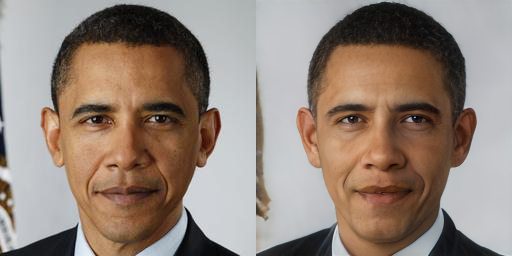

In [ ]:
res = np.concatenate([np.array(input_vis_image1.resize((256, 256))),
                          np.array(output_image_pt.resize((256, 256)))], axis=1)

res_image1 = Image.fromarray(res)
res_image1

## Converting the model to ONNX

Sources:
- https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
- https://pytorch.org/docs/stable/onnx.html
- https://colab.research.google.com/drive/1XUxWVZK4Vj4d7H53RQj5FxmxLkbmBY6h?usp=sharing#scrollTo=2V0NHmowbjH2
- https://docs.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-convert-model

### What happens?

1) Pytorch has the ONNX tool build in, which can format pytorch model to the universal ONNX format

2) Once we have the model save in .onnx format, we can load it from disk and then use "onnx_tf", to actually convert the model to tf.

3) Once the model is loaded into a tf representation, you can call the .run() method to mimic the pytorch res() method.

Lastly, do keep in mind that after conversion the regular pytorch tensors would not work anymore since tensorflow works with numpy arrays. So when doing inference you don't have to move tensors to and from the cpu with calls like "some_arr.detach().to(device).








In [ ]:
!pwd

/content


# Skipping the conversion?

You can also skip this step and continue from the cell after this, since I already ran the conversion and in there you just load the model from disk in our shared drive.

However...., I do recommand researching it a bit and check if you understand the code. Since this is a valuable thing to know (I believe), plus with this you can maybe even convert another psp model or perhaps the current one if it's not working correctly

In [ ]:
# Output of shape 1000, confidence scores for each of the imagenet classes
# Now we will save this model.
import torch.onnx

# # I am not using a GPU here, if you are, move it to cuda
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

def export_onnx_model(model, onnx_model_path):
    with torch.no_grad():
        # Bring full model to cpu for conversion
        model.to(device)

        # Format input image into a batch format the model can use
        inp_batch = transformed_image1.unsqueeze(0)

        # Run the model once on the same input we give it for onnx to run
        _, _ = model(inp_batch.float(), randomize_noise=False, return_latents= True)
        print("\n\n --------------ONNXX LETS GO ------------------\n\n")

        # Inputs needed for onnx to run 1 inference session so it can determine the graph it needs to convert
        inputs = (inp_batch.float(),
                  {"randomize_noise": False,
                  "return_latents": True})
        
        # Convert our pytroch model to onnx, so we can later on convert it to tf
        torch.onnx.export(model,                                            
                          inputs,
                          onnx_model_path,                                  
                          opset_version=12,
                          # do_constant_folding=True,
                          # See: https://github.com/pytorch/fairseq/issues/3395
                          operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK,
                          export_params=True,               
                          # input_names=['input_ids',                         
                          #              'input_code',
                          #              'return_latents']
                          )
        
        print("ONNX Model exported to {0}".format(onnx_model_path))



export_onnx_model(net, "../output/psp.onnx")




 --------------ONNXX LETS GO ------------------




/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/content/drive/MyDrive/StyleTransferProject/PSP/v3_pixel2style2pixel/models/psp.py:78: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input

ONNX Model exported to ../output/mnist.onnx


## Exporting StyleGan2's generator model

The PSP model uses their own version of StyleGan2, including their own pre-trained generator that's inside the main model. 
For our usecase where we want to alter the latent space, we'll need to have the same generator that's inside the PSP model to call it seperately.



In [ ]:
from models.stylegan2.model import Generator

def get_keys(d, name):
    if 'state_dict' in d:
        d = d['state_dict']
    d_filt = {k[len(name) + 1:]: v for k, v in d.items()
              if k[:len(name)] == name}
    return d_filt

decoder = Generator(1024, 512, 8)

print('Loading pSp from checkpoint: {}'.format(opts.checkpoint_path))
ckpt = torch.load(opts.checkpoint_path, map_location='cpu')
decoder.load_state_dict(get_keys(ckpt, 'decoder'), strict=True)



Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt


<All keys matched successfully>

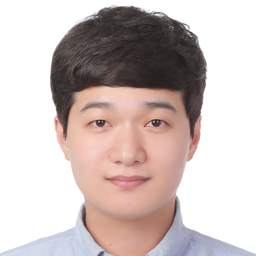

In [ ]:
# Image to run before conversion
original_image_path = './notebooks/images/Dongyun.jpg'

original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")
original_image.resize((256, 256))

In [ ]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image_dongyun = img_transforms(original_image)

In [ ]:
age_vector = np.load('./stylegan2directions/age.npy')
print(age_vector.shape)

degree = 5

(18, 512)


In [ ]:
device = "cpu"

def export_onnx_decoder_model(model, inp_batch, onnx_model_path):
    with torch.no_grad():
        # Bring full model to cpu for conversion
        model.to(device)

        # Format input image into a batch format the model can use
        # inp_batch = inp_batch.unsqueeze(0)

        # Run the model once on the same input we give it for onnx to run
        _, _ = model([inp_batch], input_is_latent=True, randomize_noise=False, return_latents=False)
        print("\n\n --------------ONNXX LETS GO ------------------\n\n")

        # Inputs needed for onnx to run 1 inference session so it can determine the graph it needs to convert
        inputs = ([inp_batch],
                  {"input_is_latent":True,
                    "randomize_noise": False,
                  "return_latents": True})
        
        # Convert our pytroch model to onnx, so we can later on convert it to tf
        torch.onnx.export(model,                                            
                          inputs,
                          onnx_model_path,                                  
                          opset_version=12,
                          # do_constant_folding=True,
                          # See: https://github.com/pytorch/fairseq/issues/3395
                          operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK,
                          export_params=True,               
                          # input_names=['input_ids',                         
                          #              'input_code',
                          #              'return_latents']
                          )
        
        print("ONNX Model exported to {0}".format(onnx_model_path))



ori_image, ori_vector = run_on_batch(transformed_image_dongyun.unsqueeze(0), net, latent_mask)

old_vector = ori_vector + torch.from_numpy(age_vector.astype(np.float32)) * degree

export_onnx_decoder_model(decoder, old_vector, "../output/decoder.onnx")

NO LATENT


 --------------ONNXX LETS GO ------------------




/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/content/drive/My Drive/Colab Notebooks/MLOps CS215/StyleTransferProject/PSP/v3_pixel2style2pixel/models/stylegan2/model.py:488: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might 

ONNX Model exported to ../output/decoder.onnx


## Convert the .onnx files to tensorflow graph format

We can load the ONNX models directly into tensorflow with their "onnx_tf" function, or we can save the model in a format that tensorflow can understand and then read them out directly from their graph in TF.


Source:
- https://towardsdatascience.com/converting-a-simple-deep-learning-model-from-pytorch-to-tensorflow-b6b353351f5d


## .pb -> Protocol Buffer format
Format used to hold models in tensorflow, which in tf is called SavedModel protocol bugger. This is the default format when saving Keras/TF 2.0 models.

When you save a model with .save('my_model') in tf, there will be a folder create like
```
my_model
 - my_model.pb
 - assets/
 - variables/
```

When loading the model with "tf.saved_model.load(model_path)", then you would need to specify the path to the <b>folder</b> and not the .pb file itself.

Which in our case is a bit harder, since we only have the .pb file format.

Sources:
- https://stackoverflow.com/questions/51278213/what-is-the-use-of-a-pb-file-in-tensorflow-and-how-does-it-work
- https://stackoverflow.com/questions/33759623/how-to-save-restore-a-model-after-training





In [ ]:
import onnx
from onnx_tf.backend import prepare
tic = time.time()

# Load ONNX model and convert to TensorFlow format
model_psp_onnx = onnx.load('../output/mnist.onnx')
model_decoder_onnx = onnx.load('../output/decoder.onnx')

# Load onnx model into onnx_tf representation
tf_psp_rep = prepare(model_psp_onnx)
tf_decoder_rep = prepare(model_decoder_onnx)

# Export models as .pb file
tf_psp_rep.export_graph('../output/psp.pb')
tf_decoder_rep.export_graph('../output/decoder.pb')

# Timer ends
toc = time.time()
print('Loading and converting onnx models to tf and saving as pb, took {:.4f} seconds.'.format(toc - tic))

KeyboardInterrupt: ignored

# Running both the ONNX TF models

Sources:
- https://github.com/onnx/tutorials/blob/master/tutorials/OnnxTensorflowImport.ipynb
- https://github.com/onnx/onnx-tensorflow



In [ ]:
# Vasco's Path to the psp repo in our shared folder
# psp_path = "/content/drive/My Drive/Colab Notebooks/MLOps CS215/StyleTransferProject/PSP/v3_pixel2style2pixel"

# Dongyun's Path to the psp repo in our shared folder (I believe)
psp_path = "/content/drive/MyDrive/StyleTransferProject/PSP/v3_pixel2style2pixel"

# Set current working directory
os.chdir(psp_path)

In [ ]:
import onnx
from onnx_tf.backend import prepare

def load_pb(path_to_pb):
    with tf.gfile.GFile(path_to_pb, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

**Load psp model**

In [ ]:
tic = time.time()

# Convert model to tensorflow
model_psp = onnx.load('../output/mnist.onnx')
tf_rep_psp = prepare(model_psp)

toc = time.time()
print('Loading and converting PSP onnx to tf took {:.4f} seconds.'.format(toc - tic))

Loading and converting PSP onnx to tf took 40.9854 seconds.


**Load styleGAN2 decoder model**

In [ ]:
tic = time.time()

# Convert model to tensorflow
model_dec = onnx.load('../output/decoder.onnx')
tf_rep_dec = prepare(model_dec)

toc = time.time()
print('Loading and converting StyleGan2 Decoder onnx to tf took {:.4f} seconds.'.format(toc - tic))

Loading and converting StyleGan2 Decoder onnx to tf took 2.1813 seconds.


**Load input image**

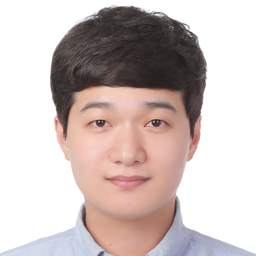

In [ ]:
# Image to run before conversion
original_image_path = './notebooks/images/Dongyun.jpg'

original_image = Image.open(original_image_path)
original_image = original_image.convert("RGB")
original_image = original_image.resize((256, 256))
original_image

**Transform original image to match it with input type, using numpy (not torch)**

In [ ]:
# Now it has some errors...


# np_original_image = np.array(original_image)
# print(np_original_image.shape)

# tic = time.time()
# result_img_tf, result_vec_tf = tf_rep_psp.run(np_original_image, randomize_noise=False, return_latents= True)
# toc = time.time()
# print('Inference took {:.4f} seconds.'.format(toc - tic))

**Transform original image to match it with input type, using torch (this process needs to be replaced with TF or numpy library)**

In [ ]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image_dongyun = img_transforms(original_image)
print(transformed_image_dongyun.shape)
transformed_image_dongyun
# print(type(transformed_image_dongyun))

torch.Size([3, 256, 256])


tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.6863, 0.6078, 0.6000,  ..., 0.6157, 0.7804, 0.9137],
         [0.6000, 0.5922, 0.5765,  ..., 0.4510, 0.4824, 0.5373],
         [0.6157, 0.6157, 0.6784,  ..., 0.4667, 0.4902, 0.4902]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7176, 0.6471, 0.6549,  ..., 0.6314, 0.7804, 0.9137],
         [0.6471, 0.6235, 0.6392,  ..., 0.4824, 0.4980, 0.5294],
         [0.6392, 0.6392, 0.7098,  ..., 0.4824, 0.4902, 0.4902]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
# Format input image into a batch format the model can use
inp_batch = transformed_image_dongyun.unsqueeze(0)
# inp_batch.float()
np_arr = inp_batch.cpu().detach().numpy()
print(np_arr.shape)
np_arr

(1, 3, 256, 256)


array([[[[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [0.6862745 , 0.60784316, 0.6       , ..., 0.6156863 ,
          0.78039217, 0.9137255 ],
         [0.6       , 0.5921569 , 0.5764706 , ..., 0.45098042,
          0.48235297, 0.5372549 ],
         [0.6156863 , 0.6156863 , 0.6784314 , ..., 0.4666667 ,
          0.4901961 , 0.4901961 ]],

        [[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [0.7176471 , 0.64705884, 0.654902  , ..., 0.6313726 ,
          0.78039217, 0.9

In [ ]:
# Format input image into a batch format the model can use
inp_batch = transformed_image_dongyun.unsqueeze(0)
inp_batch.float()
np_arr = inp_batch.cpu().detach().numpy()
print(np_arr.shape)

tic = time.time()
result_img_tf, result_vec_tf = tf_rep_psp.run(np_arr, randomize_noise=False, return_latents= True)
toc = time.time()
print('Inference took {:.4f} seconds.'.format(toc - tic))

(1, 3, 256, 256)
Inference took 72.3890 seconds.


In [ ]:
# output
print(result_img_tf.shape)
print(result_vec_tf.shape)

(1, 3, 256, 256)
(1, 18, 512)


In [ ]:
# I adjusted the default implementation of tensor2im to not use "to.device()", since it's in tf now
def tensor2imtf(image_tensor, imtype=np.uint8, normalize=True):
    if isinstance(image_tensor, list):
        image_numpy = []
        for i in range(len(image_tensor)):
            image_numpy.append(tensor2im(image_tensor[i], imtype, normalize))
        return image_numpy
    image_numpy = image_tensor
    if normalize:
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0     
    image_numpy = np.clip(image_numpy, 0, 255)
    if image_numpy.shape[2] == 1 or image_numpy.shape[2] > 3:       
        image_numpy = image_numpy[:,:,0]
    return image_numpy.astype(imtype)

In [ ]:
# input_vis_image1 = log_input_image(transformed_image1, opts)
output_image_tf = tensor2imtf(result_img_tf[0])

output_image_tf.shape
# result_image_pt

(256, 256, 3)

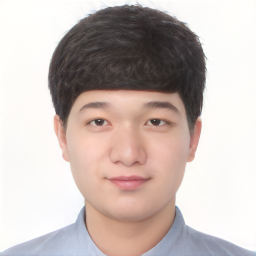

In [ ]:
# input_vis_image1 = log_input_image(transformed_image1, opts)
output_image_tf2 = output_image_tf.copy()

res_image_tf = Image.fromarray(output_image_tf2)
res_image_tf

# Further work -> Implemmenting the latent transformations.

I just tried the very simple example of matching the obama image in the latent space (I believe), I didn't have time to do the actual latent space exploration and all. 

@Dongyun, just make sure you use np.arrays and not pytorch tensors for the code. 

In [ ]:
current_path = '/content/drive/MyDrive/StyleTransferProject/PSP/v3_pixel2style2pixel/'

age_vector_file = os.path.join(current_path, 'stylegan2directions/age.npy')
gender_vector_file = os.path.join(current_path, 'stylegan2directions/gender.npy')
eyes_open_vector_file = os.path.join(current_path, 'stylegan2directions/eyes_open.npy')




age_degree = 5
gender_degree = 5
eyes_open_degree = 5


age_vector = np.load(age_vector_file)
print(age_vector.shape)

(18, 512)


In [ ]:
old_vector = result_vec_tf + age_vector * degree
young_vector = result_vec_tf - age_vector * degree

In [ ]:
type(old_vector)

numpy.ndarray

In [ ]:
old_vector = np.float32(old_vector)

old_img = tf_rep_dec.run([old_vector], input_is_latent=True, randomize_noise=False, return_latents=False)

In [ ]:
old_img[0].shape

(1, 3, 1024, 1024)

In [ ]:
old_image_tf = tensor2imtf(old_img[0][0])

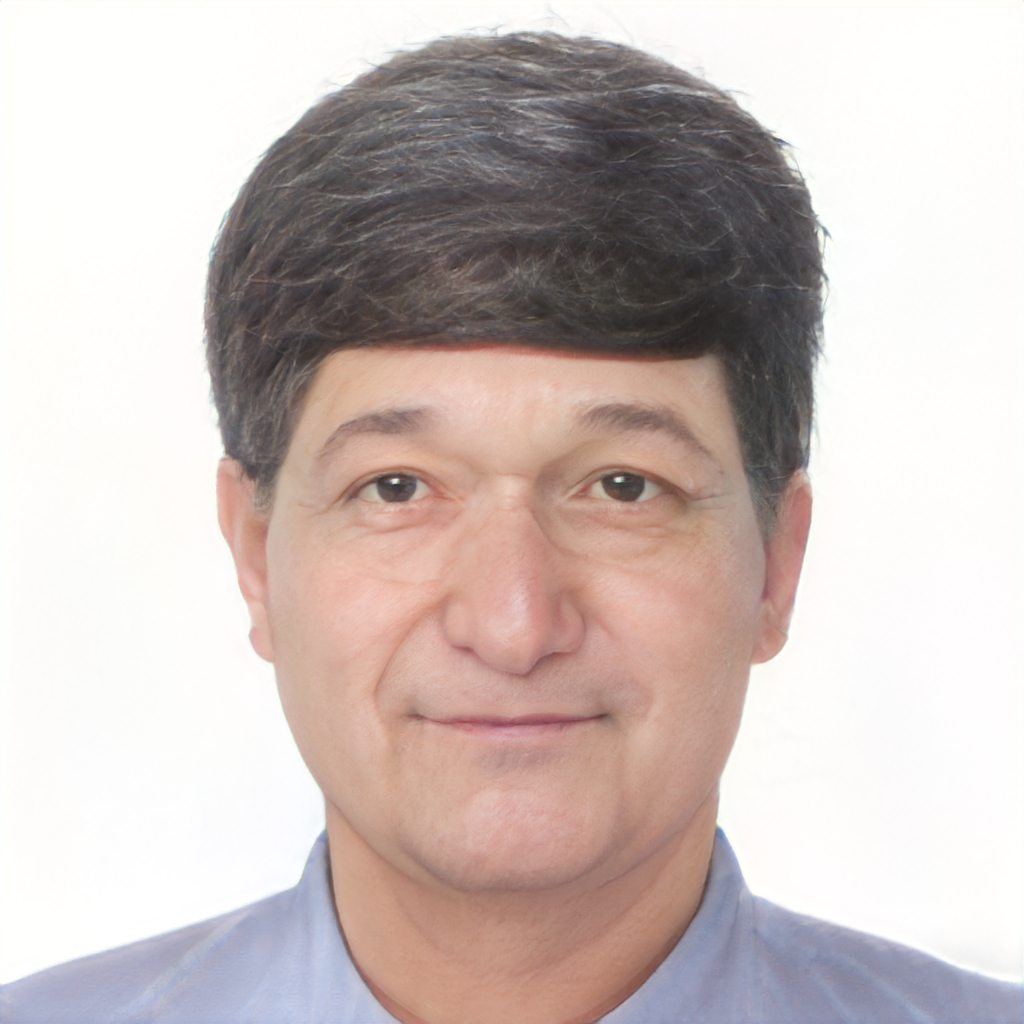

In [ ]:
old_image_tf = Image.fromarray(old_image_tf)
old_image_tf

In [ ]:
# Load input image and resize to the right format
image_path1 = './inversion_images/joe_biden.jpg'
original_image1 = Image.open(image_path1)
original_image1 = original_image1.convert("RGB")
original_image1.resize((256, 256))
input_image1 = original_image1

# Transformers input image into format needed for model from the pre-process pipeline
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image1 = img_transforms(input_image1)